In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
# from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
import seaborn as sns

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = glob.glob('/content/drive/MyDrive/Waste_Control_Data/TRAIN/O/*.jpg')
p= len(train)
# p

In [ ]:
train = glob.glob('/content/drive/MyDrive/Waste_Control_Data/TRAIN/R/*.jpg')
Q= len(train)
Q

4477

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')

Found 7473 images belonging to 2 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 1867 images belonging to 2 classes.


In [ ]:
# Class Indices
train_dataset.class_indices

{'O': 0, 'R': 1}

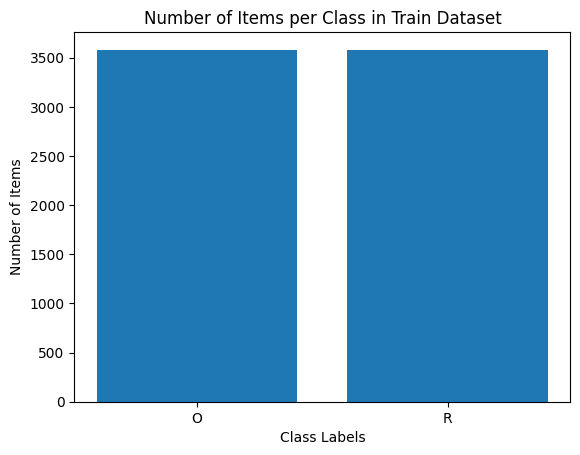

In [ ]:
# Count the number of items for each label in the train dataset
train_labels_count = train_dataset.labels.sum(axis=0)

# Get the class labels
class_labels = train_dataset.class_indices.keys()

# Plot the bar graph
plt.bar(class_labels, train_labels_count)
plt.xlabel('Class Labels')
plt.ylabel('Number of Items')
plt.title('Number of Items per Class in Train Dataset')
plt.show()

### VGG16

In [ ]:
# Defining Model VGG16
base_model = VGG16(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                       

In [ ]:
# Model Compile
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

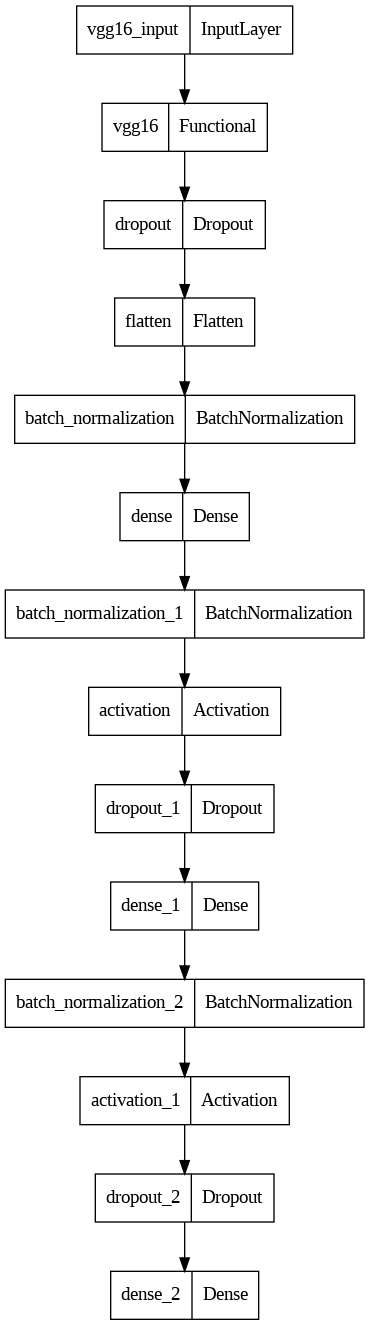

In [ ]:
# Defining Callbacks

filepath = './model.h5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]
plot_model(model, to_file='model.png')

In [ ]:
# Model Fitting

model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 0.3033 - auc: 0.9472  
Epoch 1: val_auc improved from -inf to 0.95136, saving model to ./model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 4574s 78s/step - loss: 0.3033 - auc: 0.9472 - val_loss: 0.3743 - val_auc: 0.9514
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 0.2363 - auc: 0.9663
Epoch 2: val_auc improved from 0.95136 to 0.95934, saving model to ./model.h5
59/59 [==============================] - 167s 3s/step - loss: 0.2363 - auc: 0.9663 - val_loss: 0.2663 - val_auc: 0.9593
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 0.1971 - auc: 0.9761
Epoch 3: val_auc did not improve from 0.95934
59/59 [==============================] - 157s 3s/step - loss: 0.1971 - auc: 0.9761 - val_loss: 0.3319 - val_auc: 0.9498
Epoch 4/50
59/59 [==============================] - ETA: 0s - loss: 0.1784 - auc: 0.9804
Epoch 4: val_auc did not improve from 0.95934
59/59 [==============================] - 156s 3s/step - loss: 0.1784 - auc: 0.9804 - val_loss: 0.3249 - val_auc: 0.9466
Epoch 5/50
59/59 [==============================] - ETA: 0s - loss: 0.1704 - auc:

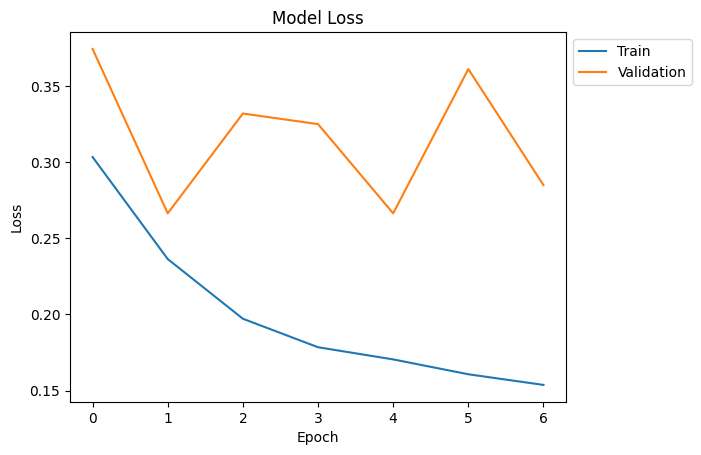

In [ ]:
# Summarize the model loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

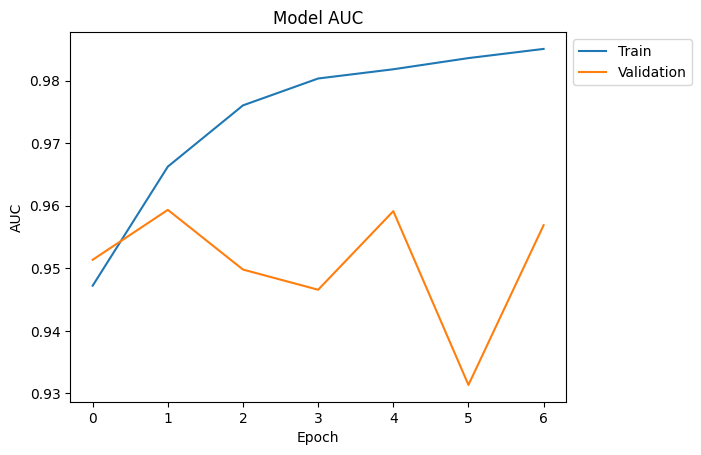

In [ ]:
# Summarize models auc
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Test Data
test_data = test_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 1956 images belonging to 2 classes.


In [ ]:
# Evaluating Loss and AUC - Test Data
model.evaluate(test_data)

16/16 [==============================] - 496s 33s/step - loss: 0.6134 - auc: 0.9016


[0.6133783459663391, 0.901577353477478]

1/1 [==============================] - 1s 1s/step
The image belongs to Organic waste category 


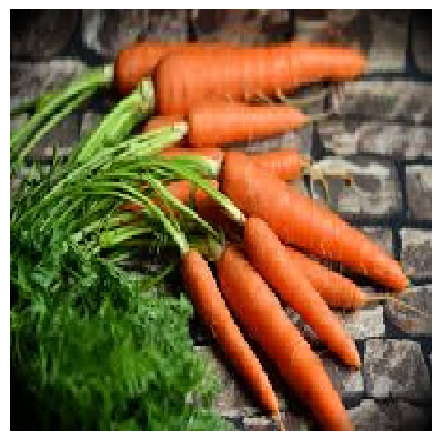

In [ ]:
# Test Case:1 - ORGANIC
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/O/O_12701.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 28ms/step
The image belongs to Recycle waste category


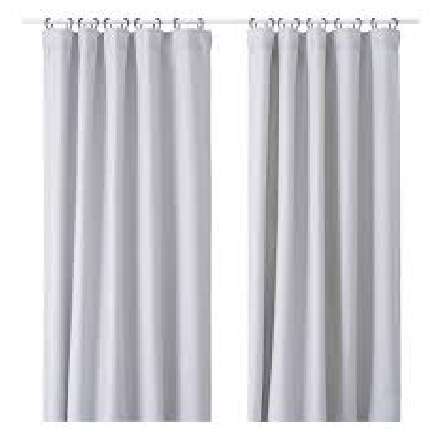

In [ ]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/R/R_10004.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [ ]:
binary_values = (y_pred >= 0.5).astype(int)

In [ ]:
reshaped_array = binary_values.reshape(1956)

In [ ]:
reshaped_array.shape

(1956,)

In [ ]:
y_true.shape

(1956,)

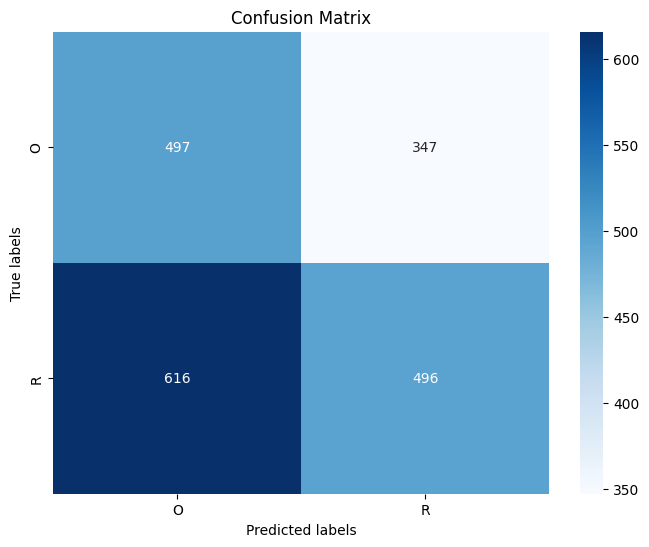

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, reshaped_array)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
test_data.reset()  # Reset generator to start of dataset
y_true = test_data.classes
y_pred = model.predict(test_data)
# y_pred_classes = np.argmax(y_pred, axis=1)

16/16 [==============================] - 15s 936ms/step


In [ ]:
binary_values_test = (y_pred >= 0.5).astype(int)

In [ ]:
# Calculate Precision, Recall, F1 Score
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, binary_values_test, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.5016848232881292
Recall: 0.4831288343558282
F1 Score: 0.4830924933454456
